In [1]:
import pandas as pd
import os
import glob

# Specify the path to your main folder containing subfolders with CSV files
main_path = r'C:\ResearchFiles\AllFiles_Cleaned'

# Recursively search for all CSV files in the subfolders
all_files = [f for f in glob.glob(os.path.join(main_path, "**/*.csv"), recursive=True)]

# Combine all files into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['smart_plug'] = os.path.basename(filename).split('_')[1]  # Add a column for the smart plug identifier
    # Optionally, add a column for the building by extracting from the path
    df['building'] = os.path.basename(os.path.dirname(filename))
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [3]:
# Remove unneccessary columns
combined_df = combined_df.drop(columns = ['analogInput_2', 'analogInput_4', 'analogInput_5', 'binaryInput_3', 'binaryValue_1', 'building'])

# Convert timestamp column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Rename the power consumption column more appropriately
combined_df = combined_df.rename(columns = {'analogInput_3': 'power_consumption (mW)'})

KeyError: "['analogInput_2', 'analogInput_4', 'analogInput_5', 'binaryInput_3', 'binaryValue_1', 'building'] not found in axis"

In [4]:
# Read in a dataset of abnormal readings to filter for only plugs without any abnormal readings
abnormal_readings = pd.read_csv(r'C:\Users\vaugh\Downloads\helper_spreadsheet(8).csv')
abnormal_readings.drop(columns=['numer_ids'], inplace=True)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].astype(str)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].apply(lambda x: x[:-2])

# Combining the datasets to include the abnormal readings column and setting time as the index
combined_df = combined_df.merge(abnormal_readings, on='smart_plug')
combined_df = combined_df[combined_df['Abnormal Readings'] == 'Clear']
combined_df.drop(columns = ['Abnormal Readings'], inplace=True)

# Set the timestamp as index for easier use when graphing
combined_df.set_index('time', inplace=True)

In [5]:
combined_df

,power_consumption (mW),smart_plug
time,,
2023-09-15 17:25:00,0.0,182280
2023-09-15 17:26:00,0.0,182280
2023-09-15 17:27:00,0.0,182280
2023-09-15 17:28:00,0.0,182280
2023-09-15 17:29:00,0.0,182280
...,...,...
2024-06-10 23:55:00,20587.0,657128
2024-06-10 23:56:00,21240.0,657128
2024-06-10 23:57:00,20760.0,657128


In [6]:
# Resample to daily intervals for easier graphing abilities
daily_df = combined_df.resample('D').mean(numeric_only=True)

In [7]:
# Convert all power consumption values from milliWatt to KW/h and rename appropriately
daily_df['power_consumption (mW)'] = daily_df['power_consumption (mW)'] / 1_000_000
daily_df.rename(columns = {'power_consumption (mW)': 'power_consumption (KW)'}, inplace=True)

In [8]:
daily_df

,power_consumption (KW)
time,
2023-09-14,0.026707
2023-09-15,0.017777
2023-09-16,NaN
2023-09-17,NaN
2023-09-18,NaN
...,...
2024-06-06,0.022624
2024-06-07,0.021281
2024-06-08,0.018072


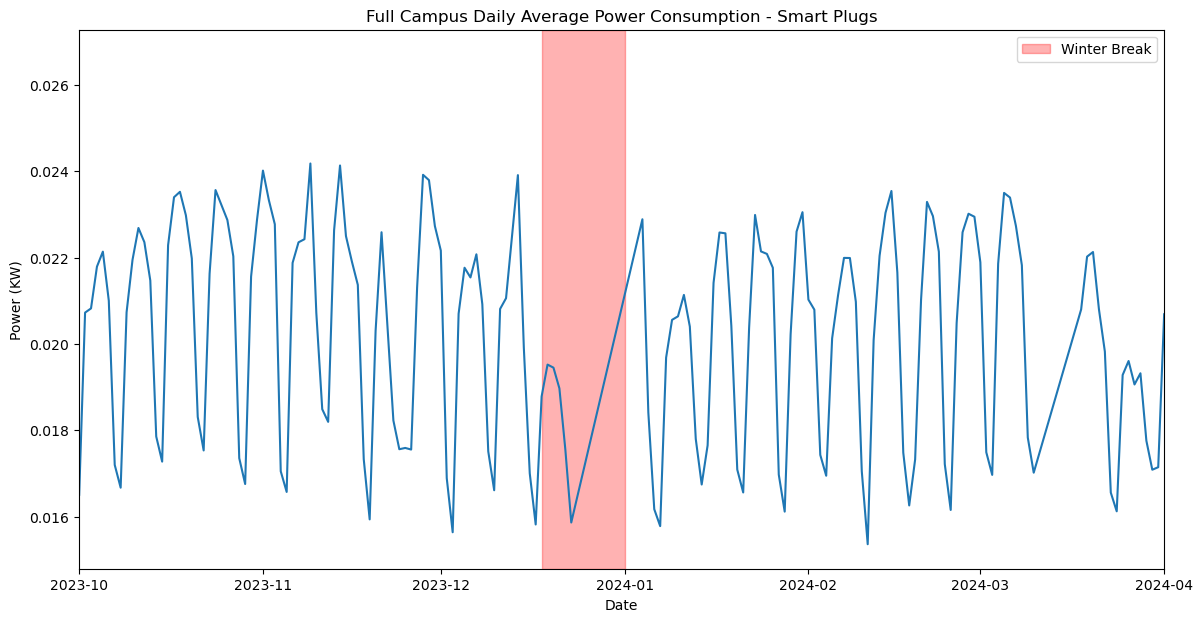

In [9]:
# Creating a graph that overlays winter break with the time series data to show the dip in power consumption during this period

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the date range to show in the plot
start_date = '2023-10-01'
end_date = '2024-04-01'

# Define the winter break date range
winter_break_start = '2023-12-18'
winter_break_end = '2024-01-01'

# Plotting overall trends
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=daily_df, x=daily_df.index, y='power_consumption (KW)')
plt.title('Full Campus Daily Average Power Consumption - Smart Plugs')
plt.xlabel('Date')
plt.ylabel('Power (KW)')

# Highlight the winter break period with a different color (e.g., light blue)
plt.axvspan(pd.to_datetime(winter_break_start), pd.to_datetime(winter_break_end), color='red', alpha=0.3, label='Winter Break')

# Set the x-axis limits
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Show the legend
plt.legend()

plt.show()